In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


import gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

from scipy.ndimage import rotate

In [2]:
sys.path.append('../../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [3]:
import elitism

In [4]:
from scipy.spatial import ConvexHull

In [5]:
import networkx as nx

In [6]:
x0, y0 = 25, 25

# FEM Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

# Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0    

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
class Prev:
    def __init__(self):
        self.prev = 100

In [28]:
T=Prev()

In [29]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    
    try:
        if np.sum(x)/(x0*y0) > 0.55:
            tmp, const = fast_stopt(args, x)
            T.prev=tmp
            if const>(55+binatodeci(individual[-4:]))/100:
                return PENALTY_VALUE, 
        else:
            return T.prev,
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [30]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [31]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min	avg    
0  	300   	100	174.725
1  	235   	100	184.254
2  	254   	100	224.089
3  	243   	100	200    
4  	233   	100	209.397
5  	242   	80.4196	135.703
6  	235   	77.8582	128.511
7  	248   	76.3925	160.843
8  	253   	75.9323	76.6313
9  	232   	75.9323	219.522
10 	251   	75.1172	214.741
11 	237   	75.1172	106.572
12 	260   	75.1172	161.192
13 	248   	74.4056	79.0354
14 	236   	74.4056	744.336
15 	241   	72.7473	513.186
16 	240   	72.7473	82.4676
17 	248   	72.7473	117.278
18 	243   	72.7473	96.243 
19 	242   	72.7473	124.686
20 	232   	72.7473	110.029
21 	243   	72.7473	98.8871
22 	240   	72.7473	111.091
23 	256   	72.7473	120.102
24 	250   	72.7473	80.9491
25 	239   	72.7473	77.352 
26 	238   	72.7473	77.3307
27 	254   	72.7473	91.984 
28 	231   	72.7473	75.7027
29 	238   	69.0995	74.0741
30 	239   	69.0995	80.0838
31 	244   	69.0995	123.301
32 	225   	69.0995	83.0861
33 	238   	69.0995	76.0998
34 	242   	69.0995	112.283
35 	239   	69.0995	117.587
36 	248   	69.0995	91.675

304	247   	29.2687	172.001
305	250   	29.1974	159.046
306	246   	29.1859	116.915
307	251   	29.1309	100.674
308	257   	29.0892	48.8229
309	249   	29.0608	32.5666
310	244   	28.8652	29.2753
311	240   	28.8072	29.1683
312	245   	28.7285	29.0926
313	240   	28.6953	29.0178
314	256   	28.5296	28.9866
315	243   	28.5296	28.8751
316	242   	28.4102	32.0087
317	240   	28.364 	28.6856
318	250   	28.2254	35.072 
319	241   	28.056 	28.5106
320	237   	27.8959	28.4155
321	248   	27.8959	28.3269
322	238   	27.7991	28.2161
323	246   	27.6104	28.1078
324	234   	27.576 	28.0336
325	246   	27.4862	27.9398
326	246   	27.36  	27.8191
327	241   	27.2124	27.7254
328	246   	27.2124	27.6244
329	247   	27.1381	27.5434
330	254   	27.0662	27.4509
331	248   	26.8541	27.3515
332	247   	26.7968	27.2588
333	249   	26.6652	30.4162
334	231   	26.5036	27.0636
335	251   	26.5036	26.9617
336	257   	26.4489	26.862 
337	250   	26.2341	26.7373
338	245   	26.2341	26.645 
339	250   	26.1431	29.7883
340	249   	26.0887	32.9429
3

608	265   	22.3892	48.5045
609	258   	22.3892	45.2478
610	249   	22.3892	51.7641
611	243   	22.3892	68.0808
612	240   	22.3892	94.1219
613	241   	22.358 	97.4141
614	248   	22.3409	110.439
615	259   	22.3409	103.907
616	246   	22.3409	116.956
617	248   	22.3409	126.71 
618	245   	22.3293	120.175
619	241   	22.3293	133.206
620	255   	22.3048	126.674
621	248   	22.3048	103.854
622	244   	22.3048	103.84 
623	242   	22.3048	97.3169
624	240   	22.3013	87.53  
625	253   	22.2992	120.107
626	246   	22.2928	129.893
627	242   	22.2928	139.655
628	249   	22.2687	129.888
629	245   	22.2637	126.624
630	246   	22.2637	126.606
631	251   	22.2634	120.09 
632	241   	22.2566	120.084
633	240   	22.2566	123.328
634	250   	22.2506	113.543
635	239   	22.2506	90.7242
636	257   	22.2506	129.834
637	247   	22.2411	97.2267
638	249   	22.2411	97.2248
639	250   	22.2333	100.493
640	254   	22.2333	97.222 
641	240   	22.2173	90.7003
642	243   	22.2173	93.9587
643	238   	22.2065	93.9575
644	237   	22.2065	126.585
6

912	255   	21.3983	171.479
913	237   	21.3899	125.81 
914	246   	21.3888	148.639
915	246   	21.3888	138.853
916	251   	21.3881	142.122
917	243   	21.3881	119.293
918	247   	21.3881	116.023
919	242   	21.3881	142.106
920	251   	21.3881	109.489
921	253   	21.3881	142.114
922	248   	21.3881	148.63 
923	243   	21.3881	125.794
924	241   	21.3862	161.673
925	243   	21.3861	168.216
926	246   	21.3861	135.594
927	249   	21.3861	125.803
928	244   	21.3861	125.81 
929	258   	21.3861	135.573
930	238   	21.3861	80.1202
931	256   	21.3861	80.1142
932	235   	21.3861	63.8107
933	251   	21.3861	93.1767
934	249   	21.3861	99.6906
935	246   	21.3861	99.6864
936	238   	21.3861	99.7024
937	244   	21.3861	76.8559
938	254   	21.3861	109.47 
939	250   	21.3861	99.6898
940	247   	21.3861	73.5995
941	247   	21.3861	96.4471
942	243   	21.3861	99.6863
943	233   	21.3861	93.1612
944	254   	21.3861	96.4363
945	234   	21.3861	102.959
946	243   	21.3861	96.4271
947	243   	21.3861	106.21 
948	257   	21.3861	83.3718
9

1208	232   	21.372 	67.048 
1209	242   	21.372 	40.9552
1210	251   	21.372 	50.7346
1211	238   	21.372 	44.2187
1212	233   	21.372 	44.2487
1213	248   	21.372 	50.7401
1214	248   	21.372 	44.2156
1215	254   	21.372 	44.2246
1216	249   	21.372 	47.4751
1217	245   	21.372 	40.9949
1218	249   	21.372 	34.431 
1219	249   	21.372 	37.703 
1220	246   	21.372 	37.6978
1221	243   	21.372 	44.2146
1222	234   	21.372 	44.2222
1223	241   	21.372 	50.7371
1224	241   	21.372 	50.7377
1225	248   	21.372 	37.6891
1226	239   	21.372 	40.9581
1227	243   	21.372 	44.2893
1228	257   	21.372 	50.7381
1229	247   	21.372 	37.6889
1230	248   	21.3703	34.4238
1231	249   	21.3703	37.7007
1232	249   	21.3703	54.0082
1233	233   	21.3703	31.1742
1234	246   	21.3703	37.6895
1235	247   	21.3703	50.7389
1236	236   	21.3703	50.7857
1237	250   	21.3703	60.5206
1238	245   	21.3703	34.4406
1239	243   	21.3703	44.2176
1240	241   	21.3703	54.0102
1241	241   	21.3703	40.9544
1242	248   	21.3703	70.3663
1243	233   	21.3695	

1501	252   	21.3063	44.1515
1502	233   	21.3063	31.1207
1503	241   	21.3063	27.8396
1504	242   	21.3063	40.8892
1505	254   	21.3063	31.1047
1506	245   	21.3063	37.6341
1507	253   	21.3063	50.6742
1508	253   	21.3063	37.6327
1509	238   	21.3063	34.3676
1510	244   	21.3063	27.8897
1511	249   	21.3063	40.9417
1512	255   	21.3063	44.1558
1513	238   	21.3063	31.1149
1514	245   	21.3063	27.8388
1515	255   	21.3063	47.4211
1516	238   	21.3063	31.1029
1517	237   	21.3063	37.6237
1518	240   	21.3063	24.5907
1519	241   	21.3063	34.3631
1520	249   	21.3063	44.1671
1521	252   	21.3063	53.9335
1522	247   	21.3063	34.367 
1523	258   	21.3063	40.8939
1524	247   	21.3063	40.8988
1525	245   	21.3063	50.684 
1526	255   	21.3063	37.6229
1527	244   	21.3063	60.4619
1528	242   	21.3063	34.3652
1529	254   	21.3063	50.6739
1530	241   	21.3063	53.9713
1531	225   	21.3063	60.4598
1532	243   	21.3063	60.47  
1533	249   	21.3063	40.9055
1534	250   	21.3063	53.9667
1535	252   	21.3063	40.9098
1536	256   	21.3063	

1794	256   	21.2885	34.3444
1795	237   	21.2885	24.557 
1796	247   	21.2885	57.1834
1797	248   	21.2885	34.3739
1798	241   	21.2885	47.4075
1799	246   	21.2885	44.1295
1800	241   	21.2885	40.9053
1801	254   	21.2885	24.5773
1802	253   	21.2885	37.6063
1803	255   	21.2885	57.2205
1804	240   	21.2885	40.9044
1805	232   	21.2885	37.6107
1806	250   	21.2885	44.1525
1807	245   	21.2885	27.8194
1808	253   	21.2885	40.8841
1809	241   	21.2885	40.8791
1810	244   	21.2885	44.1659
1811	235   	21.2885	53.9196
1812	253   	21.2885	47.3957
1813	245   	21.2857	31.0863
1814	229   	21.2857	40.8736
1815	251   	21.2857	50.6645
1816	245   	21.2857	37.6064
1817	240   	21.2857	34.3485
1818	238   	21.2857	47.401 
1819	245   	21.2857	47.3954
1820	245   	21.2857	57.1898
1821	245   	21.2857	63.7078
1822	241   	21.2857	60.4803
1823	255   	21.2857	70.2448
1824	246   	21.2857	50.6543
1825	249   	21.2857	50.6568
1826	249   	21.2857	60.4506
1827	242   	21.2793	60.4414
1828	254   	21.2793	57.1802
1829	251   	21.2793	

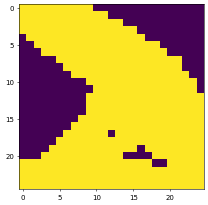

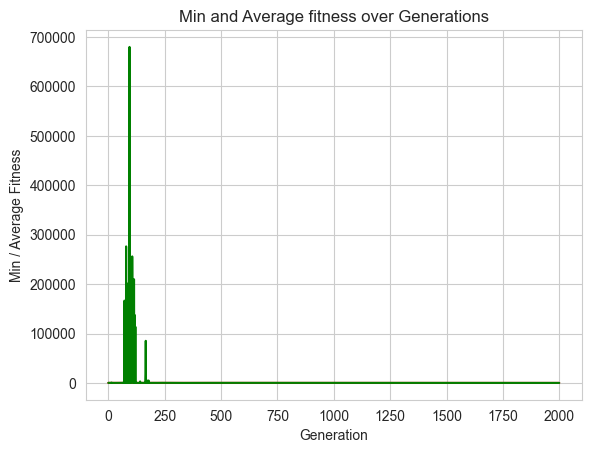

In [32]:
start = time.time()
top_ = main()
end = time.time()  

In [33]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 42.37840323448181 min


In [34]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                count = 0
                if x[i][j]==1:
                    
                
                    if 0<=i+1<self.n and x[i+1][j]==1:
                        count+=1
                    if 0<=i-1<self.n and x[i-1][j]==1:
                        count+=1 
                    if 0<=j+1<self.m and x[i][j+1]==1:
                        count+=1
                    if 0<=j-1<self.m and x[i][j-1]==1:
                        count+=1   
#                     if i==0 or i== self.n-1 or j==0 or j==self.m-1:
#                         count+=1
                
                
                    if count<4:
                        self.actions_dic[k]=(i,j)
                        k+=1
                        
                elif  x[i][j]==0:
                    x[i][j]+=1e-4
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1e-4
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [35]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,topology, normalized_image: bool = False):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
#         DIM=self.args.nelx*self.args.nely

        self.topology=topology.copy()
        self.x = self.topology.copy()

        self.M=Model(self.x)

        N_DISCRETE_ACTIONS=len(self.M.actions_dic)
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=0,
                                            high=255,
                                            shape=(self.args.nely, self.args.nelx, 1),
                                            dtype=np.float64)
        
        
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))

        self.M.action_space_(action, self.x)

        self.step_+=1
               
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        const1=np.sum(self.x)/(x0*y0)   
        
        if const1>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            tmp, const = fast_stopt(self.args, self.x)
            self.reward+=(1/tmp)**2
            self.needs_reset = True

        return self.x.reshape(x0,y0,1), self.reward, done, False, {}

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = self.topology.copy()

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(x0,y0,1), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [36]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [37]:
ts=5e6

In [38]:
# Create log dir
log_dir = "/tmp/gym_gen_1_2bdkjdn4289u/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv(topology=top_)
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for 

In [39]:
callback = SaveOnBestTrainingRewardCallback(check_freq = 100_000, log_dir = log_dir)

In [40]:
start = time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()   

Num timesteps: 100000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym_gen_1_2bdkjdn4289u/best_model.zip
Num timesteps: 200000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym_gen_1_2bdkjdn4289u/best_model.zip
Num timesteps: 300000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym_gen_1_2bdkjdn4289u/best_model.zip
Num timesteps: 400000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 500000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 600000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 700000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 800000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 900000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 1000000
Best mean reward: 0.00 - Last mean 

In [41]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 58.80236486593882 min


### Inference

In [42]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [43]:
i=0
while i<2000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones: 
        break
    i+=1

In [44]:
print(i)

625


In [45]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(5618668424.298614, 0.6816017600000001)


Final Cantilever beam design:


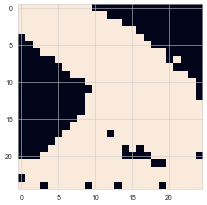

In [46]:
env.render()

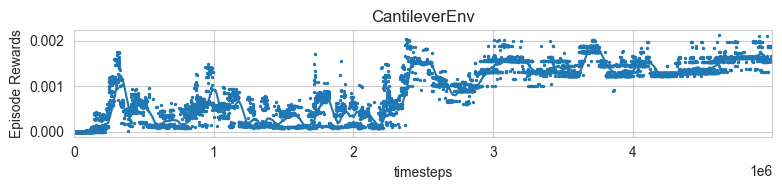

In [47]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [48]:
obs=env.reset()
obs=obs[0]

In [49]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip", env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [50]:
i=0
while i<2000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones:
        break
    i+=1

In [51]:
i

625


Final Cantilever beam design:


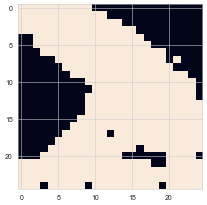

In [52]:
env.render()

In [53]:
# https://stable-baselines3.readthedocs.io/en/master/guide/save_format.html

In [54]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(21.126118647975805, 0.6816017600000001)